## Imports

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

In [2]:
# def lin_func(s, a, theta):
#     psi = np.zeros((2, theta.shape[0]))
#     psi[0, :4] = s
#     psi[1, 4:] = s
#     arr = np.array([np.dot(theta.T, psi[0]), np.dot(theta.T, psi[1])])
#     return softmax(arr), psi

# def grad_log(psi, a, probs):
#     return psi[a] - (psi[0] * probs[0] + psi[1] * probs[1])


# theta = np.array([1, 2, 3, 4, 0, 2, 3, 4])
# probs, psi = lin_func(np.array([1, 2, 3, 4]), 0, theta)

# print(probs)
# print(psi)

# grad_log(psi, 0, probs)
# # print(theta.T @ psi[1])

In [3]:
class Policy:
    def __init__(self, theta, lr, gamma):
        self.theta = theta
        self.lr = lr
        self.gamma = gamma

    # outputs psi representaion and the probability array
    def lin_func(self, s):
        psi = np.zeros((2, self.theta.shape[0]))
        psi[0, :4] = s
        psi[1, 4:] = s
        # arr = np.array([np.dot(self.theta.T, psi[0]), np.dot(self.theta.T, psi[1])])
        return psi
    
    # probs (softmax)
    def probs(self, psi):
        arr = np.array([np.dot(self.theta.T, psi[0]), np.dot(self.theta.T, psi[1])])
        return softmax(arr)
    
    # here x is the probability array or the policy itself
    def act(self, x):
        action = np.random.choice([0, 1], p=x)
        return action
    
    # gradient of the log policy
    def grad_log(self, psi, a, probs):
        return psi[a] - (psi[0] * probs[0] + psi[1] * probs[1])
    
    # discounted return
    def discount_rewards(self, rewards):
        discount_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(len(rewards))):
            cumulative_rewards = rewards[i] + cumulative_rewards * self.gamma
            discount_rewards[i] = cumulative_rewards
        return discount_rewards
    
    def update(self, rewards, states, actions):
        # print(len(rewards))
        grad_log_p = np.array([self.grad_log(self.lin_func(ob), action, self.probs(self.lin_func(ob))) for ob, action in zip(states, actions)])
        # grad_log_p_total = np.sum(grad_log_p, axis = 0)

        # assert grad_log_p_total.shape == (self.theta.shape, )
        assert grad_log_p.shape == (len(states), len(self.theta))

        # print(grad_log_p_total.shape)

        discounted_rewards = self.discount_rewards(rewards)
        # print(discounted_rewards.shape)
        dot = grad_log_p.T @ discounted_rewards

        self.theta += self.lr * dot

In [4]:
def run(env, policy):
    observation = env.reset(seed = 0)
    observation = observation[0]
    totalreward = 0

    observations = []
    actions = []
    rewards = []
    probs = []

    done = False

    for time in range(1000):
        observations.append(observation)
        prob = policy.probs(policy.lin_func(observation))
        action = policy.act(prob)

        observation, reward, done, info, _ = env.step(action)

        totalreward += reward
        rewards.append(reward)
        actions.append(action)
        probs.append(prob)

        if done:
            break

        if totalreward > env.spec.reward_threshold:
            break

    return totalreward, np.array(rewards), np.array(observations), np.array(actions), np.array(probs)

In [5]:
def train(theta, lr, gamma, Policy, MAX_EPISODES = 1000, seed = 0):
    env = gym.make('CartPole-v0')

    episode_rewards = []
    policy = Policy(theta, lr, gamma)

    for i in range(MAX_EPISODES):
        totalreward, rewards, observations, actions, probs = run(env, policy)

        policy.update(rewards, observations, actions)
        episode_rewards.append(totalreward)

        print("EP: " + str(i) + " Score: " + str(totalreward) + " ", end="\r", flush=True)

    return episode_rewards, policy

In [6]:
episode_rewards_total_grad = []

for i in range(50):
    GLOBAL_SEED = i
    np.random.seed(GLOBAL_SEED)

    episode_rewards_total_grad.append(train(np.random.rand(8), 0.01, 0.99, Policy=Policy, MAX_EPISODES=2000, seed = GLOBAL_SEED)[0])

episode_rewards_total_grad = np.array(episode_rewards_total_grad)

episode_rewards_mean_grad = np.mean(episode_rewards_total_grad, axis = 0)

episode_rewards_mean_grad

/home/srikar/anaconda3/envs/env/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/srikar/anaconda3/envs/env/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


array([ 20.  ,  26.94,  29.94, ..., 135.38, 135.58, 134.12])

In [7]:
episode_rewards_std_grad = np.std(episode_rewards_total_grad, axis = 0)

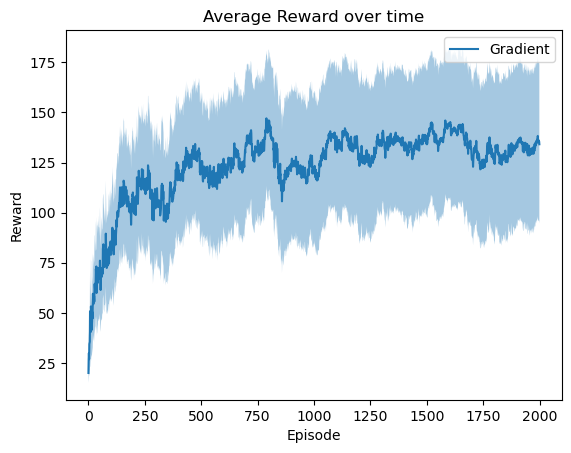

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# plt.plot(episode_rewards_mean_newton, label = 'Newton')
plt.plot(episode_rewards_mean_grad, label = 'Gradient')
plt.fill_between(np.arange(len(episode_rewards_mean_grad)), episode_rewards_mean_grad - 0.5*episode_rewards_std_grad, episode_rewards_mean_grad + 0.5*episode_rewards_std_grad, alpha=0.4)
# plt.plot(episode_rewards_mean_perb, label = 'Perturb')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average Reward over time')
plt.legend()
# plt.savefig('/home/srikar/Srikar/pnrl/Reward_plots/combine_newton_grad_perb_seeds_20.png')
plt.show()

In [10]:
import pandas as pd

data = pd.DataFrame()

data['Episode'] = np.arange(len(episode_rewards_mean_grad))
data['Reward Mean'] = episode_rewards_mean_grad
data['Reward Std'] = episode_rewards_std_grad

data.to_csv('gradient_output.csv', index = False)